In [17]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from runge_kutta import RungeKuttaSolver

In [18]:
# Функции, задающие правые части исходных уравнений
def function_x(a, b, v):
    x = v[1]
    y = v[2]
    return a * x - b * x * y

def function_y(c, d, v):
    x = v[1]
    y = v[2]
    return -c * y  + d * x * y


In [19]:
# Функции, задающие правые части соответствующих уравнений производных по парамтерам
# для X
def dx_da_f(v, a, b):
    x = v[1]
    y = v[2]
    dx_da = v[3]
    dy_da = v[7]

    return x + (a - b * y) * dx_da - b * x * dy_da

def dx_db_f(v, a, b):
    x = v[1]
    y = v[2]
    dx_db = v[4]
    dy_db = v[8]

    return -x * y + (a - b * y) * dx_db - b * x * dy_db

def dx_dc_f(v, a, b):
    x = v[1]
    y = v[2]
    dx_dc = v[5]
    dy_dc = v[9]

    return (a - b * y) * dx_dc - b * x * dy_dc

def dx_dd_f(v, a, b):
    x = v[1]
    y = v[2]
    dx_dd = v[6]
    dy_dd = v[10]

    return (a - b * y) * dx_dd - b * x * dy_dd

# для Y
def dy_da_f(v, c, d):
    x = v[1]
    y = v[2]
    dx_da = v[3]
    dy_da = v[7]

    return d * y * dx_da + (d * x - c) * dy_da

def dy_db_f(v, c, d):
    x = v[1]
    y = v[2]
    dx_db = v[4]
    dy_db = v[8]

    return d * y * dx_db + (d * x - c) * dy_db

def dy_dc_f(v, c, d):
    x = v[1]
    y = v[2]
    dx_dc = v[5]
    dy_dc = v[9]

    return -y + d * y * dx_dc + (d * x - c) * dy_dc

def dy_dd_f(v, c, d):
    x = v[1]
    y = v[2]
    dx_dd = v[6]
    dy_dd = v[10]

    return x * y + d * y * dx_dd + (d * x - c) * dy_dd

In [20]:
# Решаем исходную эталонную систему
np.random.seed(0)

# Задаем параметры
a = b = 2
c = d = 1

# область интегрирования
t_begin = 0
t_end = 6

# число точек сетки
n_points = 100

# шаг сетки
h = (t_end - t_begin) / (n_points - 1)

# функции, задающие правые части уравнений с фиксированными параметрами
x_f = lambda v: function_x(a, b, v)
y_f = lambda v: function_y(c, d, v)

# начальные условия
x0 = 1
y0 = 3

# решение
reference_solver = RungeKuttaSolver([x_f, y_f], [x0, y0], t_begin, t_end, h)

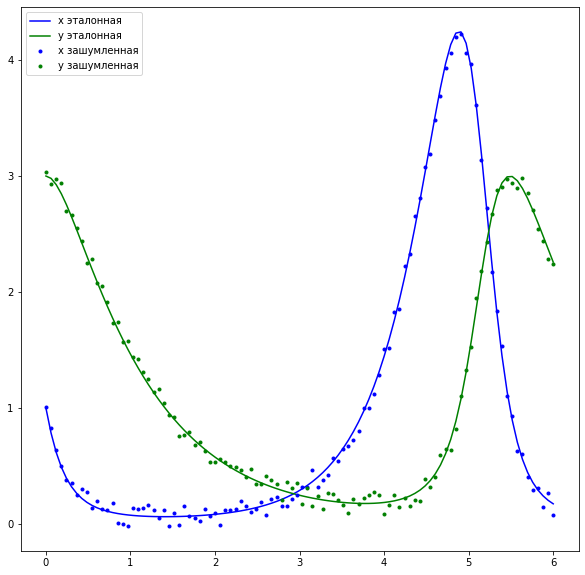

In [21]:
# получаем точки
ts = [t_begin + h * i for i in range(n_points)]

# получаем точки решения
x = [reference_solver(0, t) for t in ts]
y = [reference_solver(1, t) for t in ts]

# получаем зашумленные точки
x_noised = [reference_solver(0, t) + np.random.rand() * 0.2 - 0.1 for t in ts]
y_noised = [reference_solver(1, t) + np.random.rand() * 0.2 - 0.1 for t in ts]
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(ts, x, 'b', label='x эталонная')
ax.plot(ts, y, 'g', label='y эталонная')

ax.plot(ts, x_noised, 'b.', label='x зашумленная')
ax.plot(ts, y_noised, 'g.', label='y зашумленная')

ax.legend()
plt.show()

In [22]:

# Начальные значения для искомых параметров
a0 = b0 = 1.75
c0 = d0 = 0.875

initial_conditions = [x0, y0, 0, 0, 0, 0, 0, 0, 0, 0] # вектор начальных условий

grad_descent_h = 0.012 # скорость градиентного спуска
beta = 0.75 # коэффициент "обновления градиента", т.е. cur_delta = -cur_grad * h * beta + (1 - beta) * prev_grad 
eps = 1e-4 # порог, при достижении которого величиной изменения вектора параметра, спуск можно считать завершенным
max_iters = 1000 # максимальное разрешенное число итераций градиентного спуска
grad_descent_h_multiplier = 0.9998 # число, на которое будет умножаться скорость градиентного
# спуска на каждой итерации для уменьшения скачков на месте

# Проинициализируем заранее переменные для сдвигов по параметрам,
# чтобы использовать импульс при градиентном спуске
da = db = dc = dd = 0

# Инициализируем искомые параметрами начальными значениями
cur_a = a0
cur_b = b0
cur_c = c0
cur_d = d0

iter = 0 # номер итерации
while True:
    # Фиксируем текущие значения параметров во всех функциях
    # Для фазовых переменных
    x_f = lambda v: function_x(cur_a, cur_b, v)
    y_f = lambda v: function_y(cur_c, cur_d, v)

    # Для производных по параметрам
    xa_f = lambda v: dx_da_f(v, cur_a, cur_b)
    xb_f = lambda v: dx_db_f(v, cur_a, cur_b)
    xc_f = lambda v: dx_dc_f(v, cur_a, cur_b)
    xd_f = lambda v: dx_dd_f(v, cur_a, cur_b)

    ya_f = lambda v: dy_da_f(v, cur_c, cur_d)
    yb_f = lambda v: dy_db_f(v, cur_c, cur_d)
    yc_f = lambda v: dy_dc_f(v, cur_c, cur_d)
    yd_f = lambda v: dy_dd_f(v, cur_c, cur_d)

    # Формируем набор правых частей для полной системы ОДУ
    #            0    1    2     3     4     5     6     7     8     9        
    functions = [x_f, y_f, xa_f, xb_f, xc_f, xd_f, ya_f, yb_f, yc_f, yd_f]

    # Решатель при текущих параметрах для функций X, Y и всевозможных производных по параметрам
    solver = RungeKuttaSolver(functions, initial_conditions, t_begin, t_end, h)

    # ==== ВЫЧИСЛЕНИЕ ГРАДИЕНТА ====
    dj_da = dj_db = dj_dc = dj_dd = 0

    for t in ts:  
        # Разница между значением решения при текущих параметрах и эталонным решением
        delta_x = (solver(0, t) - reference_solver(0, t)) # для функции X
        delta_y = (solver(1, t) - reference_solver(1, t)) # для функции Y

        # частные производные по параметрам
        # для функции X
        dx_da = solver(2, t)
        dx_db = solver(3, t)
        dx_dc = solver(4, t)
        dx_dd = solver(5, t)
        
        # для функции Y
        dy_da = solver(6, t)
        dy_db = solver(7, t)
        dy_dc = solver(8, t)
        dy_dd = solver(9, t)

        dj_da += delta_x * dx_da + delta_y * dy_da
        dj_db += delta_x * dx_db + delta_y * dy_db
        dj_dc += delta_x * dx_dc + delta_y * dy_dc
        dj_dd += delta_x * dx_dd + delta_y * dy_dd

    dj_da *= 2
    dj_db *= 2
    dj_dc *= 2
    dj_dd *= 2

    # делим на число точек, чтобы, собственно, отстроиться от числа точек
    dj_da /= n_points
    dj_db /= n_points
    dj_dc /= n_points
    dj_dd /= n_points

    # ==============================

    prev_da = da
    prev_db = db
    prev_dc = dc
    prev_dd = dd

    # градиентый спуск и импульсом
    da = dj_da * grad_descent_h * beta + prev_da * (1 - beta)
    db = dj_db * grad_descent_h * beta + prev_db * (1 - beta)
    dc = dj_dc * grad_descent_h * beta + prev_dc * (1 - beta)
    dd = dj_dd * grad_descent_h * beta + prev_dd * (1 - beta)

    cur_a -= da
    cur_b -= db
    cur_c -= dc
    cur_d -= dd

    # уменьшение скорочти спуска
    grad_descent_h *= grad_descent_h_multiplier

    delta_squared = da*da + db*db + dc*dc + dd*dd
    delta = np.sqrt(delta_squared)

    print(f'{iter=} {delta=} {grad_descent_h=} {da=} {db=} {dc=} {dd=}', end='\r')

    # проверка условия для останова
    if delta < eps or iter >= max_iters:
        break
    iter += 1
    
print('\nCompleted!')
print(f'{cur_a=} {cur_b=} {cur_c=} {cur_d=}')

iter=825 delta=9.991737116772293e-05 grad_descent_h=0.010172521633790406 da=-7.467181200009629e-05 db=-5.9289797512121495e-05 dc=2.632353330418567e-05 dd=1.4120660715626825e-0555553
Completed!
cur_a=1.9506956269032725 cur_b=1.964237288635705 cur_c=1.0183178104987105 cur_d=1.011245263184864


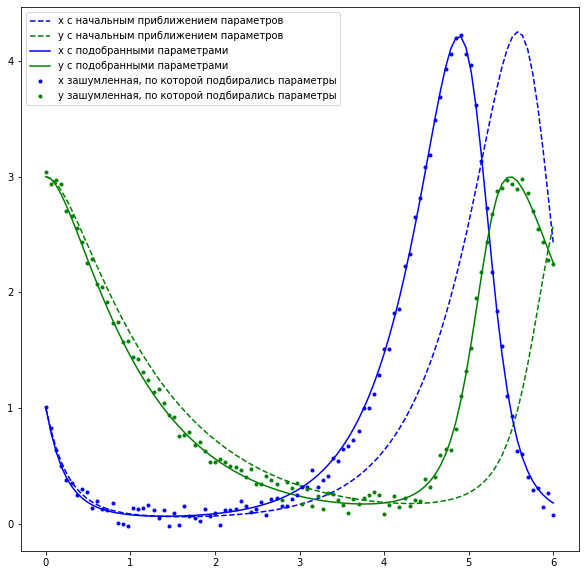

In [23]:
# Фиксируем параметры для правых частей полученного решения
x_f = lambda v: function_x(cur_a, cur_b, v)
y_f = lambda v: function_y(cur_c, cur_d, v)

# Фиксируем параметры для изначалньной (зашумленной функции)
x_f_initial = lambda v: function_x(a0, b0, v)
y_f_initial = lambda v: function_y(c0, d0, v)

# Решаем зашумленную задачу при начальных условиях
initial_solver = RungeKuttaSolver([x_f_initial, y_f_initial], [x0, y0], t_begin, t_end, h)

# Решаем задачу при подобранных параметрах
solver = RungeKuttaSolver([x_f, y_f], [x0, y0], t_begin, t_end, h)

# Точки решения с начальным приближением параметров
x_initial = [initial_solver(0, t) for t in ts]
y_initial = [initial_solver(1, t) for t in ts]

# Точки решения после подбора параметров
x = [solver(0, t) for t in ts]
y = [solver(1, t) for t in ts]

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(ts, x_initial, 'b--', label='x c начальным приближением параметров')
ax.plot(ts, y_initial, 'g--', label='y c начальным приближением параметров')
ax.plot(ts, x, 'b', label='x с подобранными параметрами')
ax.plot(ts, y, 'g', label='y с подобранными параметрами')
ax.plot(ts, x_noised, 'b.', label='x зашумленная, по которой подбирались параметры')
ax.plot(ts, y_noised, 'g.', label='y зашумленная, по которой подбирались параметры')

ax.legend()

plt.show()

Видно, что подбор параметров прошел успешно. Изначально, сильно отличающущееся (даже визуально) решение системы сошлось к хорошему приближению зашумленных эталонных функций.